# Data Wrangling COVID-19 Mini-Challenge

## Imports and Setup

In [24]:
import pandas as pd
from datetime import date
from glob import glob
import seaborn as sns
import plotly.offline as pyo
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
import os

# with this renderer, the plots are also shown in the html file.
pio.renderers.default = "jupyterlab"

## International COVID-data

In [2]:
today = date.today()
dates = [date.strftime('%m-%d-%Y') for date in pd.date_range(start='2020-01-22', end=today)][:-1]
dates_as_date = pd.date_range(start='2020-01-22', end=today)[:-1]


# standardize column names for all entries
def rename_columns(column):
    column_map = {
        'Lat': 'Latitude',
        'Long_': 'Longitude',
        'Incidence_Rate': 'Incident_Rate'
    }
    if column in column_map:
        return column_map[column]
    return column.replace('/', '_').replace('-', '_').replace(' ', '_')

all_cases = []
for d in range(len(dates)):
    path = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{}.csv".format(dates[d])
    data = pd.read_csv(path)
    data.rename(columns=rename_columns, inplace=True)
    data['Date'] = dates_as_date[d]
    all_cases.append(data)

df = pd.concat(all_cases)

In [3]:
# all_cases.Country_Region.unique()

# standardize country names for all entries
country_mapping = {
    'MS Zaandam|Diamond Princess|Cruise Ship': 'Others', # move cruise ships to others
    'Hong Kong.+': 'Hong Kong',
    'Iran.+': 'Iran',
    '.*Congo.*': 'Congo',
    'Mainland China': 'China',
    '.*Bahamas.*': 'The Bahamas',
    '.*Gambia.*': 'The Gambia',
    'Viet Nam': 'Vietnam',
    'Taiwan\*': 'Taiwan',
    'Cote d\'Ivoire': 'Ivory Coast',
    'Cabo Verde': 'Cape Verde',
    'Russian Federation': 'Russia',
    ' Azerbaijan': 'Azerbaijan',
    'Holy See': 'Vatican City',
    'Republic of Ireland': 'Ireland',
    'Republic of Moldova': 'Moldova',
    'Czechia': 'Czech Republic',
    'Republic of Korea|Korea, South': 'South Korea',
    'Timor-Leste': 'East Timor',
    'Macao SAR|Macau': 'Macao',
    'UK': 'United Kingdom',
    'Jersey|Guernsey': 'Channel Islands',
    'Dominican Republicn Republic|Dominica': 'Dominican Republic'
}

df['Country_Region'].replace(
    to_replace=country_mapping.keys(),
    value=country_mapping.values(),
    regex=True,
    inplace=True
)

In [4]:
df.to_csv('worldwide.csv')

In [5]:
df = pd.read_csv('worldwide.csv')

C:\Users\joelt\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning:

Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.



In [6]:
# group data by country
daily_updates = df.groupby(['Country_Region', 'Date']).agg(
     Confirmed = ('Confirmed','sum'),
     Deaths = ('Deaths','sum'),
 ).reset_index()

In [7]:
# get changes in data
updates_per_country = daily_updates.groupby('Country_Region')
# diff takes difference to point in group before it
daily_updates['New_Confirmed'] = updates_per_country['Confirmed'].diff().fillna(0)
daily_updates['New_Deaths'] = updates_per_country['Deaths'].diff().fillna(0)

In [8]:
# reorder columns
worldwide_pretty = daily_updates.loc[:, ['Date', 'Country_Region', 'New_Confirmed', 'Confirmed', 'New_Deaths', 'Deaths']]

## Plotting International Data

In [9]:
# create df with one column per date
worldwide_all = worldwide_pretty.groupby('Date').agg(
    Confirmed = ('Confirmed', 'sum'),
    New_Confirmed = ('New_Confirmed', 'sum')
)
# create a moving average
worldwide_all['SMA_14'] = round(worldwide_all.loc[:,'New_Confirmed'].rolling(window=14).mean())
worldwide_all = worldwide_all.reset_index()

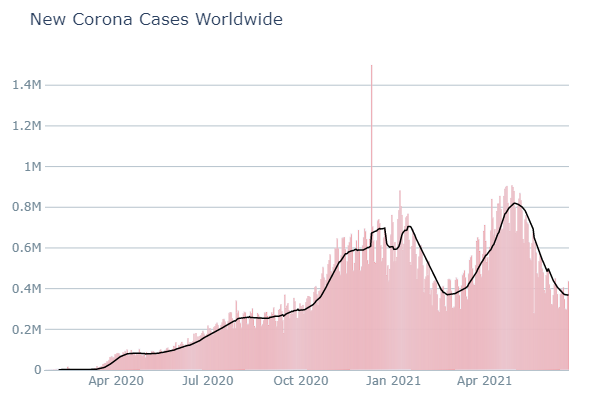

In [10]:
plot = go.Figure()

plot.add_trace(
    go.Bar(
        name='Daily Meas',
        x=worldwide_all["Date"], 
        y=worldwide_all["New_Confirmed"],
        marker={
            # size': 10,
            'color': 'red',
            'opacity': 1
        },
    )
)

plot.add_trace(
    go.Scatter(
        name='14 Day MA',
        x=worldwide_all["Date"], 
        y=worldwide_all["SMA_14"],
        mode='lines',
        marker={
            'size': 1,
            'color': 'black',
            'opacity': 0.7
        },
        line_width=1.5
    )
)


plot.update_layout(
    title_x=0,
    title='New Corona Cases Worldwide',
    margin={
        'l': 25,
        'b': 25,
        't': 50,
        'r': 20
    },
    height=400,
    yaxis={
        'color': '#748B99',
        'showgrid': True,
        'showline': True,
        'gridwidth': 1,
        'gridcolor': '#B6C3CC',
        # 'rangemode': "tozero",
        'range':
            [0,
             worldwide_all.New_Confirmed.max() * 1.05],
        # 'ticksuffix': ' '
        # 'tickprefix': 'id: '
    },
    xaxis={
        'showgrid': False,
        'color': '#748B99',
        'showline': True,
        'linecolor': '#B6C3CC',
    },
    paper_bgcolor='#FFFFFF',
    plot_bgcolor='rgba(0,0,0,0)',
    showlegend=False,
    legend={
        'yanchor': 'top',
        'y': 0.99,
        'xanchor': 'right',
        'x': 0.99
    })

plot.show()

In [12]:
# create df with one column per date
df = worldwide_pretty[worldwide_pretty.Country_Region == 'Ireland']
# create a moving average
df['SMA_14'] = round(df.loc[:,'New_Confirmed'].rolling(window=14).mean())
df = df.reset_index()

<ipython-input-12-0d67e925aa0e>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



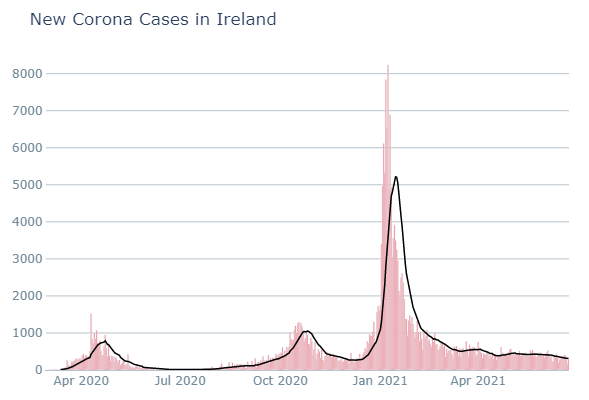

In [13]:
plot = go.Figure()

plot.add_trace(
    go.Bar(
        name='Daily Meas',
        x=df["Date"], 
        y=df["New_Confirmed"],
        marker={
            # size': 10,
            'color': 'red',
            'opacity': 1
        },
    )
)

plot.add_trace(
    go.Scatter(
        name='14 Day MA',
        x=df["Date"], 
        y=df["SMA_14"],
        mode='lines',
        marker={
            'size': 1,
            'color': 'black',
            'opacity': 0.7
        },
        line_width=1.5
    )
)


plot.update_layout(
    title_x=0,
    title='New Corona Cases in Ireland',
    margin={
        'l': 25,
        'b': 25,
        't': 50,
        'r': 20
    },
    height=400,
    yaxis={
        'color': '#748B99',
        'showgrid': True,
        'showline': True,
        'gridwidth': 1,
        'gridcolor': '#B6C3CC',
        # 'rangemode': "tozero",
        'range':
            [0,
             df.New_Confirmed.max() * 1.05],
        # 'ticksuffix': ' '
        # 'tickprefix': 'id: '
    },
    xaxis={
        'showgrid': False,
        'color': '#748B99',
        'showline': True,
        'linecolor': '#B6C3CC',
    },
    paper_bgcolor='#FFFFFF',
    plot_bgcolor='rgba(0,0,0,0)',
    showlegend=False,
    legend={
        'yanchor': 'top',
        'y': 0.99,
        'xanchor': 'right',
        'x': 0.99
    })

plot.show()

## Swiss COVID-data

In [14]:
# data import
path = "https://raw.githubusercontent.com/openZH/covid_19/master/COVID19_Fallzahlen_CH_total_v2.csv"
chData = pd.read_csv(path)

In [15]:
# only use data from 1 june on
chData = chData[chData.date > '2020-06-01']

# remove Fürstentum Lichtenstein
chData = chData[chData.abbreviation_canton_and_fl != 'FL']

# calculate new cases and deaths
chGrouped = chData.groupby('abbreviation_canton_and_fl')
chData['new_cases'] = chGrouped['ncumul_conf'].diff().fillna(0)
chData['new_deaths'] = chGrouped['ncumul_deceased'].diff().fillna(0)

# calculate total cases and deaths
chData['total_cases'] = chGrouped['new_cases'].cumsum()
chData['total_deaths'] = chGrouped['new_deaths'].cumsum()

# remove obsolete columns
chData = chData[[
    'date',
    'abbreviation_canton_and_fl',
    'new_cases',
    'total_cases',
    'new_deaths',
    'total_deaths'
]]

# rename columns
chData = chData.rename(
    {
    'abbreviation_canton_and_fl': 'canton'
    },
    axis='columns'
)

## Plotting Swiss Data

In [16]:
# create df with one column per date
df = chData.groupby('date').agg(
    Confirmed = ('total_cases', 'sum'),
    New_Confirmed = ('new_cases', 'sum')
)
# create a moving average
df['SMA_14'] = round(df.loc[:,'New_Confirmed'].rolling(window=14).mean())
df = df.reset_index()

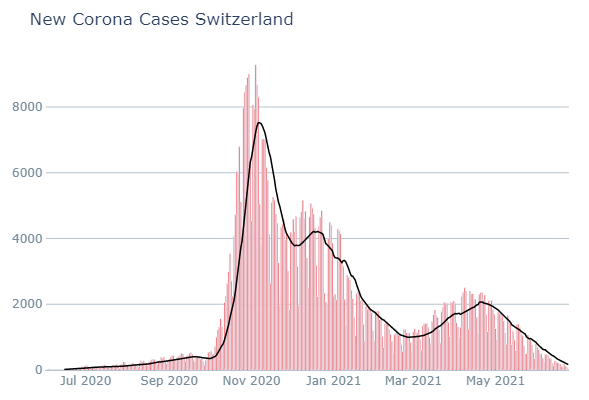

In [17]:
plot = go.Figure()

plot.add_trace(
    go.Bar(
        name='Daily Meas',
        x=df["date"], 
        y=df["New_Confirmed"],
        marker={
            # size': 10,
            'color': 'red',
            'opacity': 1
        },
    )
)

plot.add_trace(
    go.Scatter(
        name='14 Day MA',
        x=df["date"], 
        y=df["SMA_14"],
        mode='lines',
        marker={
            'size': 1,
            'color': 'black',
            'opacity': 0.7
        },
        line_width=1.5
    )
)


plot.update_layout(
    title_x=0,
    title='New Corona Cases Switzerland',
    margin={
        'l': 25,
        'b': 25,
        't': 50,
        'r': 20
    },
    height=400,
    yaxis={
        'color': '#748B99',
        'showgrid': True,
        'showline': True,
        'gridwidth': 1,
        'gridcolor': '#B6C3CC',
        # 'rangemode': "tozero",
        'range':
            [0,
             df.New_Confirmed.max() * 1.05],
        # 'ticksuffix': ' '
        # 'tickprefix': 'id: '
    },
    xaxis={
        'showgrid': False,
        'color': '#748B99',
        'showline': True,
        'linecolor': '#B6C3CC',
    },
    paper_bgcolor='#FFFFFF',
    plot_bgcolor='rgba(0,0,0,0)',
    showlegend=False,
    legend={
        'yanchor': 'top',
        'y': 0.99,
        'xanchor': 'right',
        'x': 0.99
    })

plot.show()

In [18]:
# create df with one column per date
df = chData[chData.canton == 'BE']
# create a moving average
df['SMA_14'] = round(df.loc[:,'new_cases'].rolling(window=14).mean())
df = df.reset_index()

<ipython-input-18-5ba604c9944e>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



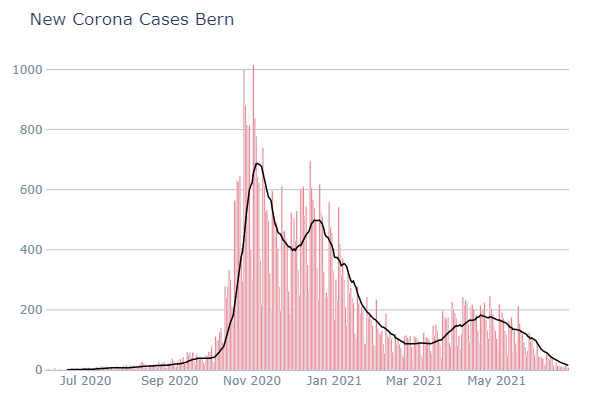

In [19]:
plot = go.Figure()

plot.add_trace(
    go.Bar(
        name='Daily Meas',
        x=df["date"], 
        y=df["new_cases"],
        marker={
            # size': 10,
            'color': 'red',
            'opacity': 1
        },
    )
)

plot.add_trace(
    go.Scatter(
        name='14 Day MA',
        x=df["date"], 
        y=df["SMA_14"],
        mode='lines',
        marker={
            'size': 1,
            'color': 'black',
            'opacity': 0.7
        },
        line_width=1.5
    )
)


plot.update_layout(
    title_x=0,
    title='New Corona Cases Bern',
    margin={
        'l': 25,
        'b': 25,
        't': 50,
        'r': 20
    },
    height=400,
    yaxis={
        'color': '#748B99',
        'showgrid': True,
        'showline': True,
        'gridwidth': 1,
        'gridcolor': '#B6C3CC',
        # 'rangemode': "tozero",
        'range':
            [0,
             df.new_cases.max() * 1.05],
        # 'ticksuffix': ' '
        # 'tickprefix': 'id: '
    },
    xaxis={
        'showgrid': False,
        'color': '#748B99',
        'showline': True,
        'linecolor': '#B6C3CC',
    },
    paper_bgcolor='#FFFFFF',
    plot_bgcolor='rgba(0,0,0,0)',
    showlegend=False,
    legend={
        'yanchor': 'top',
        'y': 0.99,
        'xanchor': 'right',
        'x': 0.99
    })

plot.show()

## Dataframes

In [20]:
worldwide_pretty.head(3)

,Date,Country_Region,New_Confirmed,Confirmed,New_Deaths,Deaths
0,2020-02-24,Afghanistan,0.0,1.0,0.0,0.0
1,2020-02-25,Afghanistan,0.0,1.0,0.0,0.0
2,2020-02-26,Afghanistan,0.0,1.0,0.0,0.0


In [21]:
chData.head(3)

,date,canton,new_cases,total_cases,new_deaths,total_deaths
2384,2020-06-02,BL,0.0,0.0,0.0,0.0
2385,2020-06-02,FR,0.0,0.0,0.0,0.0
2386,2020-06-02,GR,0.0,0.0,0.0,0.0


## Exports and HTML-file creation

In [22]:
# export the dataframes
chData.to_csv('covid_ch.csv')
worldwide_pretty.to_csv('covid_international.csv')

In [26]:
# create a html file
os.system('jupyter nbconvert --to html data_pipeline.ipynb')

0